In [2]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import math

# Selective catalytic Reduction

## Thermal model

### Test 1.5

In [3]:
# SCR Geometry
L = 1 # m
D = 0.1 # m
t = 0.01 # m
d = D - 2 * t # m
# relative roughness
e = 0.001 # m
e_D = e / D # /

# Exhaus gases from a diesel car engine
rho_eg = 1.2 # kg/m^3
velocity_eg = 20 # m/s
kinematic_viscosity_eg = 1.5e-5 # m^2/s
dynamic_viscosity_eg = rho_eg * kinematic_viscosity_eg # kg/m*s
specific_heat_eg = 1000 # J/kgK
thermal_conductivity_eg = 0.024 # W/mK

Re_eg = velocity_eg * d / kinematic_viscosity_eg
Pr_eg = specific_heat_eg * dynamic_viscosity_eg / thermal_conductivity_eg
print(f"Reynolds number EG: {Re_eg:.2f}")

# Za turbulentni tok v cevi Colebrook enačba
def colebrook_eq(f, e_D, Re):
    return 1/math.sqrt(f) + 2*math.log10((e_D)/3.7 + 2.51/(Re*math.sqrt(f)))

def colebrook_friction_factor(e_D, Re):
    f_guess = 0.01
    f_tol = 1e-6
    max_iterations = 1000
    iterations = 0
    error = 1
    while error > f_tol and iterations < max_iterations:
        f_next = f_guess - colebrook_eq(f_guess, e_D, Re)/(-0.5*f_guess**(-1.5) - (2.51/(Re*f_guess**(1.5)*((e_D)/3.7 + 2.51/(Re*math.sqrt(f_guess))))))
        error = abs(f_next - f_guess)
        f_guess = f_next
        iterations += 1
    return f_guess

def darcy_friction_factor(Re, e_D):
    if Re <= 2300:
        return 64/Re
    else:
        return colebrook_friction_factor(e_D, Re)

def alpha_coefficient(Re, Pr, D, e):
    f = darcy_friction_factor(Re_eg, e/D)
    Nu = 0.023*Re**(4/5)*Pr**(0.4)*(D/e)**(0.4)
    return f*(Nu/8)*(Re - 1000)*Pr/(1 + 12.7*math.sqrt(f/2)*(Pr**(2/3) - 1))


alpha = alpha_coefficient(Re_eg, Pr_eg, D, e)
print("alpha coefficient: ", alpha)

Reynolds number EG: 106666.67
alpha coefficient:  749329.8015763917


(7.0, 387.0)

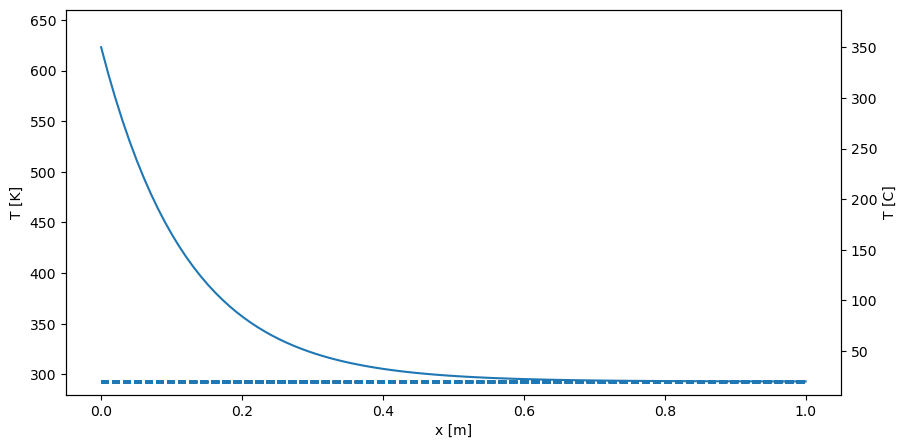

In [4]:
x = np.linspace(0, L, 100)
T = np.zeros_like(x)
T_inner_wall = np.zeros_like(x)
T_inner_wall[:] = 293
T[0] = 273+350 # K
dx = L / (len(x) - 1)
for i in range(1, len(x)):
    dTdx = -alpha * math.pi * d * (T[i-1] - T_inner_wall[i]) / (rho_eg * velocity_eg * specific_heat_eg)
    T[i] = T[i-1] + dTdx * dx
    
fig, ax = plt.subplots(figsize=(10, 5))

m = 280
M = 660
ax.plot(x, T)
ax.set_xlabel("x [m]")
ax.set_ylabel("T [K]")
ax.set_ylim(m, M)
ax.hlines(T_inner_wall, 0, L, linestyles='dashed')

ax2 = ax.twinx()
ax2.set_ylabel("T [C]")
ax2.set_ylim(m-273, M-273)


Text(0, 0.5, 'q [W/m^2]')

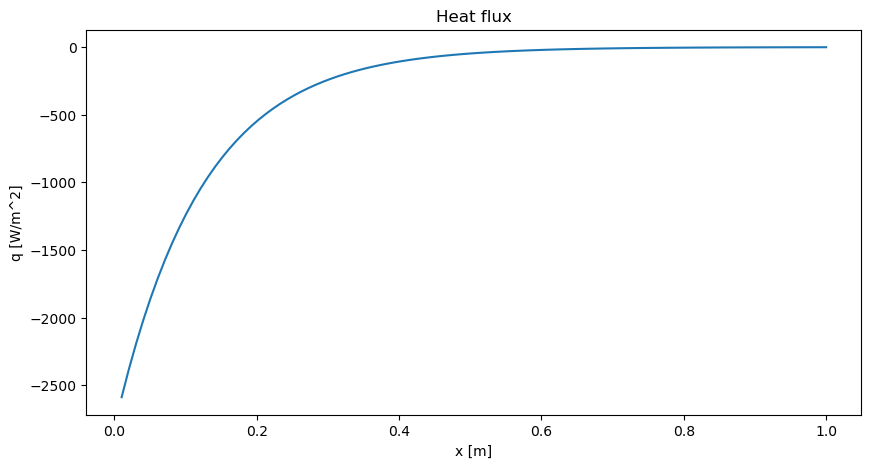

In [5]:
q = np.zeros_like(x)
for i in range(1, len(x)):
    q[i] = -alpha * math.pi * d * (T[i-1] - 293) / (rho_eg * velocity_eg * specific_heat_eg)
    
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x[1:], q[1:])
ax.set_title("Heat flux")
ax.set_xlabel("x [m]")
ax.set_ylabel("q [W/m^2]")
# ax.set_ylim(0, 1e4)


In [6]:
A_wall_middle = math.pi * ((D+d)/2) * L
A_wall_middle # m^2
lambda_wall = 0.1 # W/mK


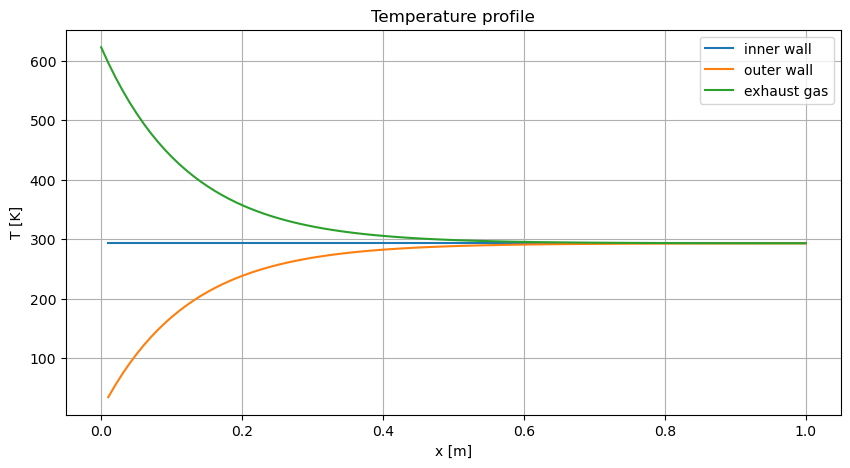

In [11]:
T_outer_wall = np.zeros_like(x)
T_outer_wall = q*t/lambda_wall + T_inner_wall

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title("Temperature profile")
ax.plot(x[1:], T_inner_wall[1:], label="inner wall")
ax.plot(x[1:], T_outer_wall[1:], label="outer wall")
ax.plot(x, T, label="exhaust gas")
ax.set_xlabel("x [m]")
ax.set_ylabel("T [K]")
ax.grid()
ax.legend()